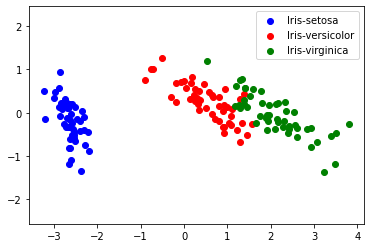

In [948]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

iris = pd.read_csv('iris.data', header=None)
train_data = iris.iloc[:,0:-1]
train_target = iris.iloc[:,-1]
def PCA(X,PC):
    mean = X.mean(0)
    A = X-mean
    u,s,vt = np.linalg.svd(A, full_matrices=True)
    return vt
x = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[0].T)
y = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[1].T)
#y2 = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[2].T)
#y3 = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[3].T)
y_number = np.array([], dtype=np.int8)
for i in range(0,len(train_target)):
    if train_target.unique()[0]==train_target[i]:
        setosa = plt.scatter(x[i],y[i],c='b')
        y_number = np.append(y_number,2)
    if train_target.unique()[1]==train_target[i]:
        versicolor = plt.scatter(x[i],y[i],c='r')
        y_number = np.append(y_number,0)
    if train_target.unique()[2]==train_target[i]:
        virginica = plt.scatter(x[i],y[i],c='g')
        y_number = np.append(y_number,1)
#colour = LabelEncoder().fit(train_target).transform(train_target)
#print(train_target.unique())
plt.axis('equal')
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()


[2.36220446 2.64770424 0.74200056]
[1 2 0]
the accuracy is 0.8866666666666667


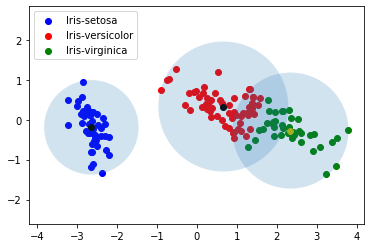

[[ 2.34645113 -0.27235455]
 [-2.64084076 -0.19051995]
 [ 0.66443351  0.33029221]]
[[-2.64084076 -0.19051995]
 [ 0.66443351  0.33029221]
 [ 2.34645113 -0.27235455]]


In [949]:
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from sklearn import metrics
#from sklearn.metrics import normalized_mutual_info_score


x_y = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[0:2,:].T)
kmean_initial = KMeans(n_clusters=3).fit(x_y)
label = kmean_initial.labels_
relabel = label.copy()
centers = kmean_initial.cluster_centers_
recenters = centers.copy()
center_ordered = np.argsort(np.argsort(np.linalg.norm(centers,axis=1)))
print(np.linalg.norm(centers,axis=1))
print(center_ordered)
#print('end')
#print(centers[0])
#print(centers[1])
#print(centers[2])

#predict=kmean_initial.predict(centers)
#print(predict)
for i in range(len(label)):
    for j in range(3):
        if center_ordered[j]!=j:
            if label[i]==j:
                relabel[i]=center_ordered[j]
for i in range(3):
    recenters[i]=centers[center_ordered[i]]

#ax = plt.scatter(x_y[:,0],x_y[:,1])
for i in range(len(label)):
    if relabel[i] == 0:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
    if relabel[i] == 1:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
    if relabel[i] == 2:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
def getRadius(center,j):
    radius =0
    for i in range(len(relabel)):
        if center_ordered[j]==relabel[i]:
            r = np.linalg.norm(x_y[i]-center)
            if r>=radius:
                radius = r
    return radius
#print(kmean_initial.cluster_centers_)
ax = plt.scatter(kmean_initial.cluster_centers_[:,0],kmean_initial.cluster_centers_[:,1],c='k')
ax = plt.axis('equal')
ax = plt.scatter(centers[0,0],centers[0,1],c='y')
ax = plt.gca()
for i in range(len(kmean_initial.cluster_centers_[:,0])):
    ax.add_patch(Circle(centers[i,:],radius=getRadius(centers[i,:],i), alpha=1/5))

score = 0
for i in range(len(y_number)):
    if y_number[i] == relabel[i]:
        score+=1
#print(y_number)
#print('next')
#print(kmean_initial.labels_)
#print(label)
#print(relabel)
#print(score)
#print(len(y_number))
#print('accuracy is',normalized_mutual_info_score(y_number,kmean_initial.labels_))
print('the accuracy is',score/len(y_number))
#confusion_matrix = metrics.cluster.contingency_matrix(y_number, kmean_initial.labels_)
#print(np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix))
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()

print(centers)
print(recenters)

In [950]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
def initialize_random_params():
    params = {'pi0': x_y[relabel==0].shape[0]/x_y.shape[0],
              'pi1': x_y[relabel==1].shape[0]/x_y.shape[0],
              'pi2': x_y[relabel==2].shape[0]/x_y.shape[0],
              'mu0': recenters[0],
              'mu1': recenters[1],
              'mu2': recenters[2],
              'sigma0': np.cov(x_y[relabel == 0].T, bias= True),
              'sigma1': np.cov(x_y[relabel == 1].T, bias= True),
              'sigma2': np.cov(x_y[relabel == 2].T, bias= True)}
    return params
params=initialize_random_params()
print(params)
def e_step(x,params):
    log_pdf = np.log([multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
                      multivariate_normal(params["mu1"], params["sigma1"]).pdf(x),
                      multivariate_normal(params["mu2"], params["sigma2"]).pdf(x)])
    log_pi_pdf = np.log([params["pi0"], params["pi1"], params["pi2"]])[np.newaxis, ...] + log_pdf.T
    log_pi_pdf_norm = logsumexp(log_pi_pdf, axis=1)
    r = np.exp(log_pi_pdf - log_pi_pdf_norm[..., np.newaxis])
    return log_pi_pdf_norm,r
def E(x,params):
    pdf0 = multivariate_normal(params["mu0"], params["sigma0"]).pdf(x)*params["pi0"]
    pdf1 = multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)*params["pi1"]
    pdf2 = multivariate_normal(params["mu2"], params["sigma2"]).pdf(x)*params["pi2"]
    pdf = np.array([pdf0,pdf1,pdf2])
    norm = np.sum(pdf,axis=0)
    return norm,np.divide(pdf,norm).T

x0,r0=E(x_y,params)
x,r=e_step(x_y,params)

def m_step(x,params):
    _,r = E(x,params)
    pi = np.array([])
    mu = np.array([])
    sigma = np.array([])
    for i in range(3):
        sum_r = np.sum(r[:,i])
        pi = np.append(pi, sum_r/x.shape[0])
        mu = np.append(mu,(r[:,i].T.dot(x)/sum_r))
        sigma = np.append(sigma,(x-mu[i]).T.dot((x-mu[i])*r[:,i][:,np.newaxis])/sum_r)
    params = {'pi0':pi[0],'pi1':pi[1],'pi2':pi[2],'mu0':mu[0:2],'mu1':mu[2:4],'mu2':mu[4:6],\
              'sigma0':sigma[0:4].reshape((2,2)),'sigma1':sigma[4:8].reshape((2,2)),\
              'sigma2':sigma[8:12].reshape((2,2))}
    return params
params2=m_step(x_y,params)
print(params2)
pdf=np.log([multivariate_normal(params['mu0'], params['sigma0']).pdf(x_y),
        multivariate_normal(params['mu1'], params['sigma1']).pdf(x_y),
        multivariate_normal(params['mu2'], params['sigma2']).pdf(x_y)])


{'pi0': 0.4066666666666667, 'pi1': 0.26, 'pi2': 0.3333333333333333, 'mu0': array([-2.64084076, -0.19051995]), 'mu1': array([0.66443351, 0.33029221]), 'mu2': array([ 2.34645113, -0.27235455]), 'sigma0': array([[ 0.3777503 , -0.10985456],
       [-0.10985456,  0.14495779]]), 'sigma1': array([[ 0.35155689, -0.10572859],
       [-0.10572859,  0.13213395]]), 'sigma2': array([[ 0.04777048, -0.05590782],
       [-0.05590782,  0.21472356]])}
{'pi0': 0.3333340023770324, 'pi1': 0.4796056142461369, 'pi2': 0.18706038337683065, 'mu0': array([-2.64083707, -0.19051817]), 'mu1': array([0.90777598, 0.23013118]), 'mu2': array([ 2.37841026, -0.25053953]), 'sigma0': array([[ 0.04777719, -0.0559045 ],
       [-0.0559045 ,  6.21878745]]), 'sigma1': array([[1.97911264, 0.22209476],
       [0.22209476, 0.37031237]]), 'sigma2': array([[ 2.33388509, -1.82503903],
       [-1.82503903,  1.48642317]])}


In [951]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x, params)
    print("pi0: %s\npi1: %s\npi2: %s\nmu_0: %s\nmu_1: %s\nmu_2: %s\nsigma0: %s\nsigma1: %s\nsigma2: %s"
               % (params['pi0'],params['pi1'],params['pi2'],params['mu0'],params['mu1'],params['mu2'],params['sigma0'],params['sigma1'],params['sigma2'],))
    _, posterior = e_step(x, params2)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods
print("unsupervised: ")
params2 = initialize_random_params()
#unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_y, params)
def EM(x, params, n):
    for i in range(n):
        params = m_step(x, params)
        print(params['pi0'],params['pi1'],params['pi2'])
    print("pi0: %s\npi1: %s\npi2: %s\nmu_0: %s\nmu_1: %s\nmu_2: %s\nsigma0: %s\nsigma1: %s\nsigma2: %s"
          % (params['pi0'],params['pi1'],params['pi2'],params['mu0'],params['mu1'],params['mu2'],params['sigma0'],params['sigma1'],params['sigma2'],))
    _,r= E(x, params)
    forecasts = np.argmax(r, axis=1)
    params = m_step(x, params)
    return params, r, n

#unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = EM(x_y, params2,0)


"""print("total steps: ", unsupervised_loglikelihoods)
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.show()
plt.close()"""

unsupervised: 


'print("total steps: ", unsupervised_loglikelihoods)\nplt.plot(unsupervised_loglikelihoods)\nplt.title("unsupervised log likelihoods")\nplt.show()\nplt.close()'

(3,)
pi0: 0.4066666666666667
pi1: 0.26
pi2: 0.3333333333333333
mu_0: [-2.64084076 -0.19051995]
mu_1: [0.66443351 0.33029221]
mu_2: [ 2.34645113 -0.27235455]
sigma0: [[ 0.3777503  -0.10985456]
 [-0.10985456  0.14495779]]
sigma1: [[ 0.35155689 -0.10572859]
 [-0.10572859  0.13213395]]
sigma2: [[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 2 2 2 1
 1 2 1 1 2 2 2 1 1 2 1 1 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 1
 2 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
(150, 2)
0.13333333333333333


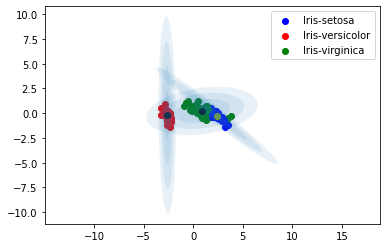

0.3333340023770324 0.4796056142461369 0.18706038337683065


In [947]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

print(unsupervised_posterior[0].shape)
for i in range(1):
    params, unsupervised_posterior, unsupervised_loglikelihoods = EM(x_y, params2,i)
    predicted = np.array([], dtype=np.int8)
    for i in range(unsupervised_posterior.shape[0]):
        index = np.argmax(unsupervised_posterior[i])
        if index ==0:
            reshuffle = 2
        if index ==1:
            reshuffle =0
        if index ==2:
            reshuffle =1
        predicted = np.append(predicted,index)
    print(predicted)
    print(y_number)
    print(x_y.shape)
    score = 0
    for i in range(len(y_number)):
        if y_number[i] == predicted[i]:
            score+=1
    print(score/150)
    for i in range(len(predicted)):
        if predicted[i] == 0:
            versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
        if predicted[i] == 1:
            virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
        if predicted[i] == 2:
            setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
    elipse_centers = np.array([params['mu0'],params['mu1'],params['mu2']])
    covariance = np.array([params['sigma0'],params['sigma1'],params['sigma2']])
    bx = plt.scatter(elipse_centers[:,0],elipse_centers[:,1],c='k')
    bx = plt.axis('equal')
    bx = plt.scatter(centers[0,0],centers[0,1],c='y')
    bx = plt.gca()
    for i in range(3):
        draw_ellipse(elipse_centers[i],covariance[i],alpha=1/10)
    #draw_ellipse()
    #draw_ellipse()
    #draw_ellipse()
    plt.legend((setosa,versicolor,virginica),(train_target.unique()))
    plt.show()
    print(params['pi0'],params['pi1'],params['pi2'])


In [930]:
"""from numpy.linalg import :                    # for matrix inverse
import random
m1 = [1,1]      # consider a random mean and covariance value
m2 = [7,7]                                              
cov1 = [[3, 2], [2, 3]]                                      
cov2 = [[2, -1], [-1, 2]]
x = np.random.multivariate_normal(m1, cov1, size=(200,))  # Generating 200 samples for each mean and covariance
y = np.random.multivariate_normal(m2, cov2, size=(200,))
d = np.concatenate((x, y), axis=0)

plt.figure(figsize=(10,10))                                 
plt.scatter(d[:,0], d[:,1], marker='o')     
plt.axis('equal')                                  
plt.xlabel('X-Axis', fontsize=16)              
plt.ylabel('Y-Axis', fontsize=16)                     
plt.title('Ground Truth', fontsize=22)    
plt.grid()            
plt.show()
m1 = random.choice(d)
m2 = random.choice(d)
cov1 = np.cov(np.transpose(d))
cov2 = np.cov(np.transpose(d))
pi = 0.5

x1 = np.linspace(-4,11,200)  
x2 = np.linspace(-4,11,200)
X, Y = np.meshgrid(x1,x2) 

Z1 = multivariate_normal(m1, cov1)  
Z2 = multivariate_normal(m2, cov2)

pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
pos[:, :, 0] = X; pos[:, :, 1] = Y   

plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
plt.scatter(d[:,0], d[:,1], marker='o')     
plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
plt.axis('equal')                                                                  # making both the axis equal
plt.xlabel('X-Axis', fontsize=16)                                                  # X-Axis
plt.ylabel('Y-Axis', fontsize=16)                                                  # Y-Axis
plt.title('Initial State', fontsize=22)                                            # Title of the plot
plt.grid()                                                                         # displaying gridlines
plt.show()
def Estep(lis1):
    m1=lis1[0]
    m2=lis1[1]
    cov1=lis1[2]
    cov2=lis1[3]
    pi=lis1[4]
    
    pt2 = multivariate_normal.pdf(d, mean=m2, cov=cov2)
    pt1 = multivariate_normal.pdf(d, mean=m1, cov=cov1)
    w1 = pi * pt2
    w2 = (1-pi) * pt1
    eval1 = w1/(w1+w2)

    return(eval1)
def Mstep(eval1):
    num_mu1,din_mu1,num_mu2,din_mu2=0,0,0,0

    for i in range(0,len(d)):
        num_mu1 += (1-eval1[i]) * d[i]
        din_mu1 += (1-eval1[i])

        num_mu2 += eval1[i] * d[i]
        din_mu2 += eval1[i]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2

    num_s1,din_s1,num_s2,din_s2=0,0,0,0
    for i in range(0,len(d)):

        q1 = np.matrix(d[i]-mu1)
        num_s1 += (1-eval1[i]) * np.dot(q1.T, q1)
        din_s1 += (1-eval1[i])

        q2 = np.matrix(d[i]-mu2)
        num_s2 += eval1[i] * np.dot(q2.T, q2)
        din_s2 += eval1[i]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2

    pi = sum(eval1)/len(d)
    
    lis2=[mu1,mu2,s1,s2,pi]
    return(lis2)
def plot(lis1):
    mu1=lis1[0]
    mu2=lis1[1]
    s1=lis1[2]
    s2=lis1[3]
    Z1 = multivariate_normal(mu1, s1)  
    Z2 = multivariate_normal(mu2, s2)

    pos = np.empty(X.shape + (2,))                # a new array of given shape and type, without initializing entries
    pos[:, :, 0] = X; pos[:, :, 1] = Y   

    plt.figure(figsize=(10,10))                                                          # creating the figure and assigning the size
    plt.scatter(d[:,0], d[:,1], marker='o')     
    plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
    plt.contour(X, Y, Z2.pdf(pos), colors="b" ,alpha = 0.5) 
    plt.axis('equal')                                                                  # making both the axis equal
    plt.xlabel('X-Axis', fontsize=16)                                                  # X-Axis
    plt.ylabel('Y-Axis', fontsize=16)                                                  # Y-Axis
    plt.grid()                                                                         # displaying gridlines
    plt.show()
iterations = 20
lis1=[m1,m2,cov1,cov2,pi]
for i in range(0,iterations):
    lis2 = Mstep(Estep(lis1))
    lis1=lis2
    if(i==0 or i == 4 or i == 9 or i == 14 or i == 19):
        plot(lis1)"""
print(0)

0


In [888]:
print(x_y[relabel==0].shape[0]/x_y.shape[0],
x_y[relabel==1].shape[0]/x_y.shape[0],
x_y[relabel==2].shape[0]/x_y.shape[0])

0.4066666666666667 0.26 0.3333333333333333
